## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import os 
import sys
import torch
import datetime
import matplotlib
import numpy as np 
import matplotlib.pylab as plt
import IPython.display as ipd


from model import Tacotron2
from train import load_model
from torch.backends import mps
from text import text_to_sequence
from hparams import create_hparams
from layers import TacotronSTFT, STFT
from waveglow.denoiser import Denoiser
from audio_processing import griffin_lim


sys.path.append('waveglow/')
%matplotlib inline

bar: str = '=='
start_time = datetime.datetime.now()
version = torch.__version__

# 新增对于Metal的后端的支持
if mps.is_available() :
    device = torch.device('mps')

elif torch.cuda.is_available() :
    device = torch.device('cuda')

else :
    device = torch.device('cpu')


print(f'INFO {start_time}')
print(f'{bar*10}Device INFO{bar*10}')
print(f'PyTorch Version :{version}')
print(f'Device :{device}')

c:\Program Files\Anaconda\envs\JP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 2022-08-13 20:27:43.979037
PyTorch Version :1.12.1+cpu
Device :cpu


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [4]:
checkpoint_path = 'tacotron2_Model\\ayachi_nene_1'#"ayachi_nene_1"
model = load_model(hparams)

if torch.cuda.is_available() :
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    model.to(device).eval()
else :
    model.load_state_dict(torch.load(checkpoint_path, map_location='cpu')['state_dict'])
    model.to(device).eval()


* **Shouw the Tacotron2 model Summary**

In [5]:
model

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

#### Load WaveGlow for mel2audio synthesis and denoiser

In [6]:
waveglow_path = 'W_Model\\model' #waveglow model
if hparams.cuda_enabled :
    waveglow = torch.load(waveglow_path)['model']
    waveglow.cuda().eval()#.half()
else :
    waveglow = torch.load(waveglow_path, map_location='cpu')['model']
    waveglow.to(device).eval()#.half()


for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

c:\Users\xbj0916\Desktop\tacotron2-japanese-master\stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)


#### Prepare text input

In [7]:
text = "こんにちは。"
sequence = np.array(text_to_sequence(text, ['japanese_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).to(device).long()

#### Decode text input and plot results

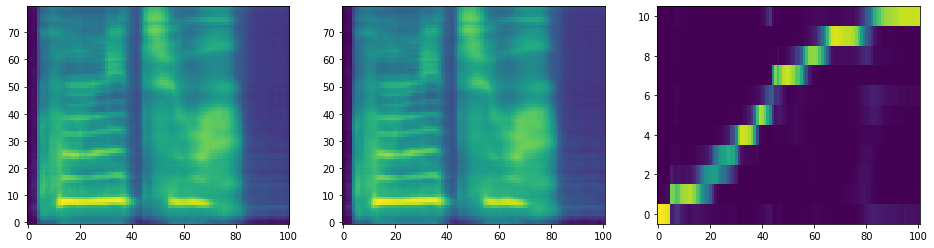

In [8]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [9]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [10]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

c:\Users\xbj0916\Desktop\tacotron2-japanese-master\audio_processing.py:50: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  win_sq = librosa_util.pad_center(win_sq, n_fft)
